In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

In [2]:
# Parameters
stocks = 'TSLA'
start_date = '2014-01-01'
end_date = '2024-12-31'
input_days_list = [60, 30, 10, 5]  # Different input days for training

In [3]:
# Download stock data
df = yf.download(stocks, start=start_date, end=end_date)
df.reset_index(inplace=True)

# Data Preparation
features = df['Close'].values
features = features.astype('float32')

[*********************100%***********************]  1 of 1 completed


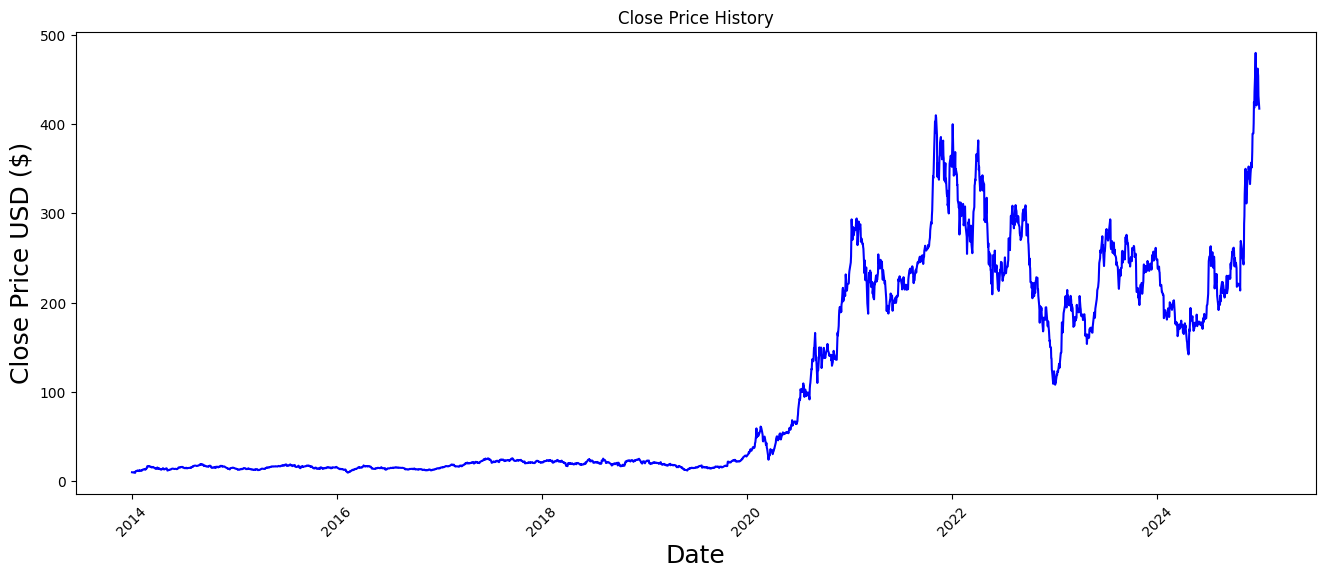

In [4]:
# Plotting the closing price
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape(-1, 1))

# Prepare sequences
training_data_len = int(np.ceil(len(scaled_features) * 0.8))

In [ ]:
# Create a function to train, predict, and visualize with various input days
def train_and_predict(input_days):
    # Create training data
    train_data = scaled_features[:training_data_len]
    x_train, y_train = [], []

    for i in range(input_days, len(train_data)):
        x_train.append(train_data[i-input_days:i])
        y_train.append(train_data[i])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for LSTM
    x_train = x_train.reshape(-1, input_days, 1)

    # Create testing data
    test_data = scaled_features[training_data_len - input_days:]
    x_test, y_test = [], []

    for i in range(input_days, len(test_data)):
        x_test.append(test_data[i-input_days:i])
        y_test.append(test_data[i])

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape x_test for LSTM
    x_test = x_test.reshape(-1, input_days, 1)

    # Initialize and compile the model
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)

    # Make predictions
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)

    # Inverse transform the predictions to get the actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Visualization of Predictions
    train = df[:training_data_len]
    valid = df[training_data_len:].copy()
    valid['Predictions'] = test_predictions.flatten()

    plt.figure(figsize=(16, 6))
    plt.title(f'LSTM Model Predictions with {input_days} Days Input')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Val', color='green')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='orange')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate performance metrics
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    mae = mean_absolute_error(valid['Close'], valid['Predictions'])
    rmse = np.sqrt(mse)
    r2 = r2_score(valid['Close'], valid['Predictions'])

    print(f"Performance metrics for input days {input_days}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("\n")

    # Plot train and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title(f'Model Train vs Validation Loss with {input_days} Days Input')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Predict the next day using the last input_days
    last_input_days = scaled_features[-input_days:]
    last_input_days = last_input_days.reshape((1, input_days, 1))

    predicted_price = model.predict(last_input_days)
    predicted_price = scaler.inverse_transform(predicted_price)

    # Display the next day's predicted price
    next_day_date = df['Date'].iloc[-1] + pd.Timedelta(days=1)
    predicted_df = pd.DataFrame(data=predicted_price, index=[next_day_date], columns=['Predicted Close'])

    print(f"Predicted stock price for {next_day_date.date()} (using last {input_days} days): ${predicted_price[0][0]:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Historical Close Prices', color='blue')
    plt.axvline(x=next_day_date, color='orange', linestyle='--', label='Prediction Date')
    plt.scatter(next_day_date, predicted_price, color='red', label='Predicted Price', s=100)

    # Add titles and labels
    plt.title('Predicted Next Day Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.grid()
    plt.show()

c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0068 - val_loss: 0.0096
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 0.0130 - val_loss: 0.0075
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 0.0105 - val_loss: 0.0075
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0210 - val_loss: 0.0057
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0140 - val_loss: 0.0045
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 0.0104 - val_loss: 0.0037
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 5.7908e-04 - val_loss: 0.0021
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9

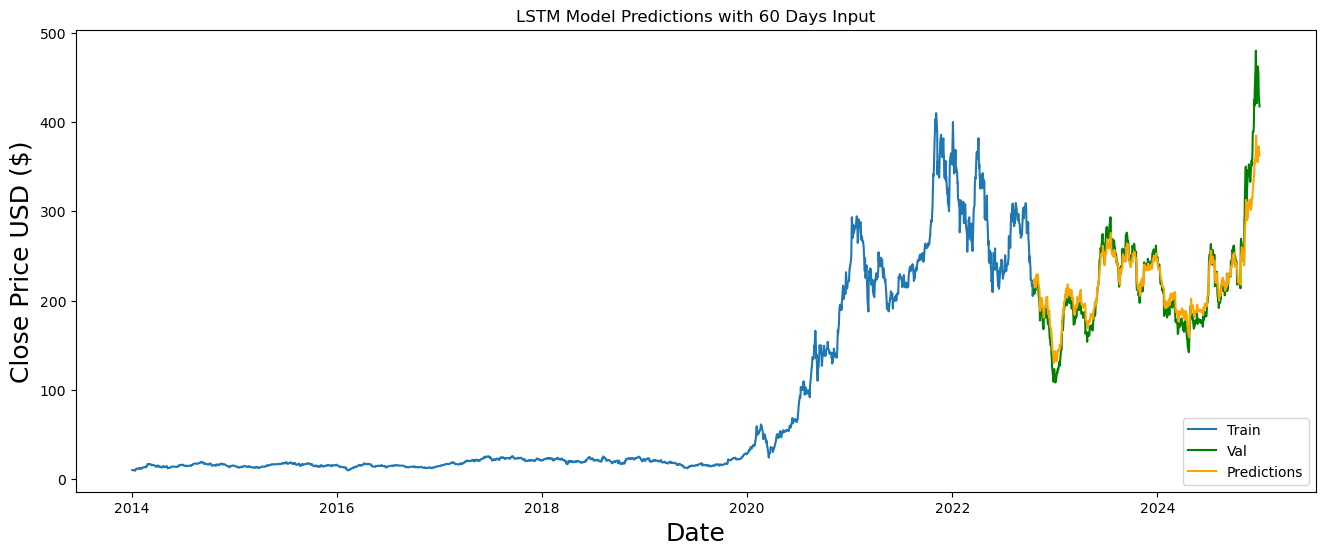

Performance metrics for input days 60:
R² Score: 0.8959
Mean Absolute Error (MAE): 12.3222
Mean Squared Error (MSE): 344.4414
Root Mean Squared Error (RMSE): 18.5591




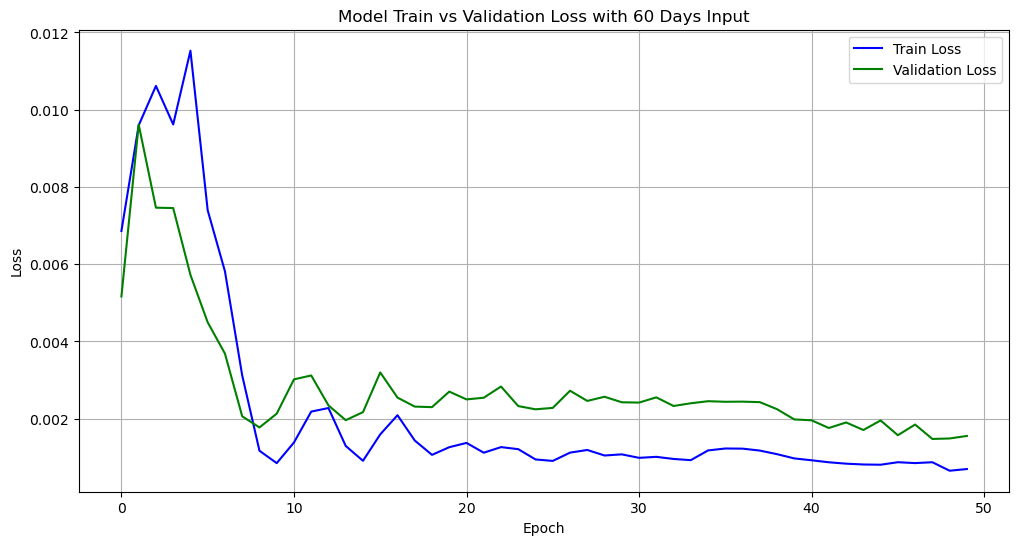

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted stock price for 2024-12-31 (using last 60 days): $353.41


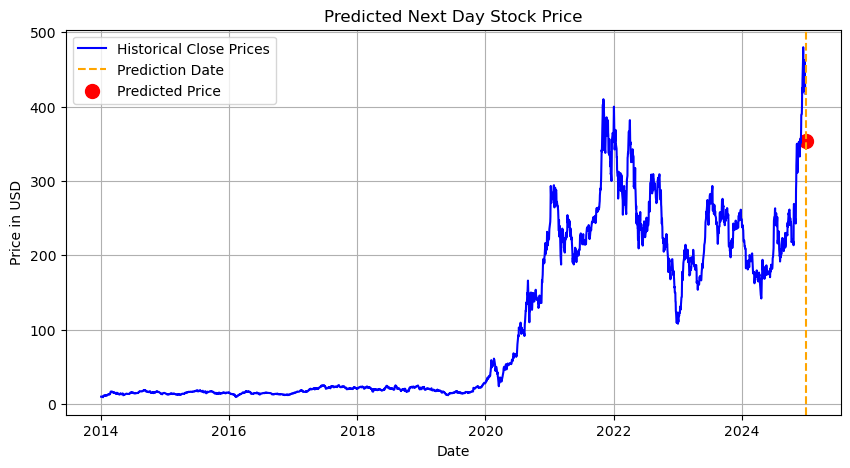

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 1.6187e-04 - val_loss: 0.0011
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0011 - val_loss: 8.7771e-04
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 1.6910

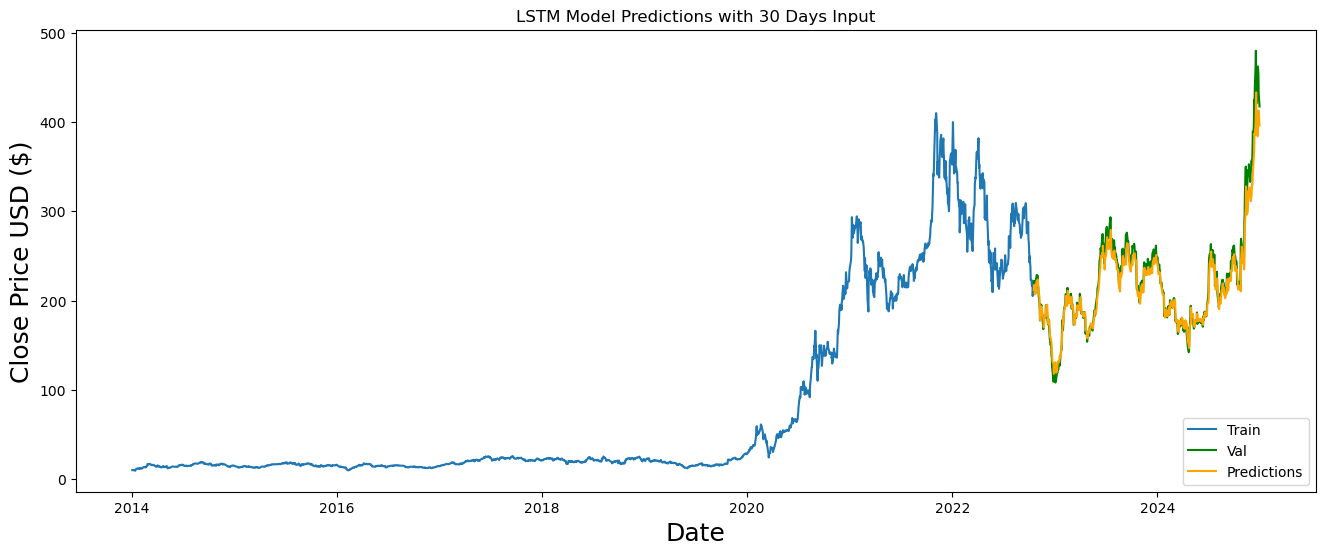

Performance metrics for input days 30:
R² Score: 0.9491
Mean Absolute Error (MAE): 8.8290
Mean Squared Error (MSE): 168.3586
Root Mean Squared Error (RMSE): 12.9753




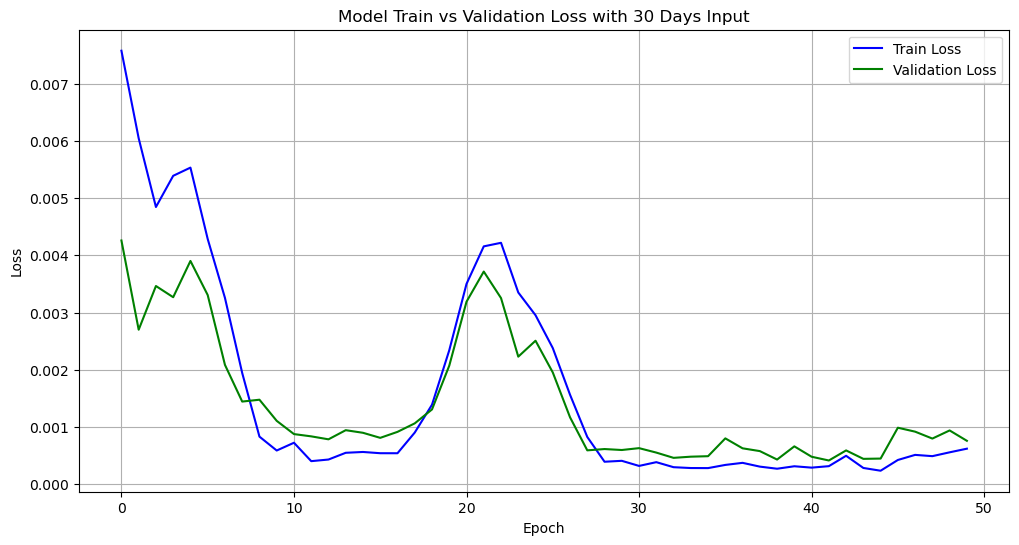

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted stock price for 2024-12-31 (using last 30 days): $381.78


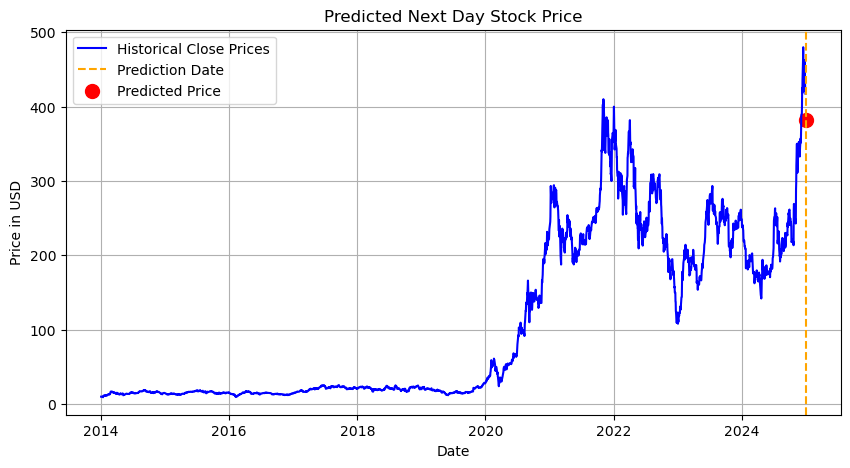

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 7.5879e-04 - val_loss: 0.0223
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0141 - val_loss: 0.0077
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0188 - val_loss: 0.0048
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0106 - val_loss: 0.0024
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.0430e-04 - val_loss: 0.0016
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.7812e-04 - val_loss: 0.0023
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.4437e-04 - val_loss: 0.0017
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.2244e-04 - val_loss: 0.0016
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - 

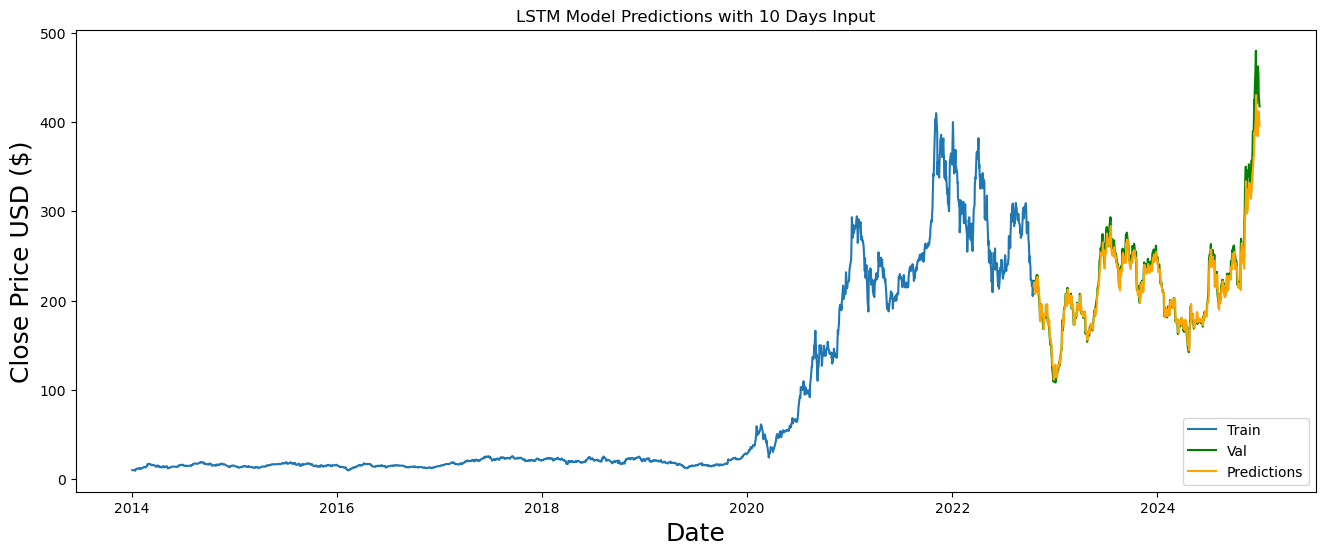

Performance metrics for input days 10:
R² Score: 0.9566
Mean Absolute Error (MAE): 7.7919
Mean Squared Error (MSE): 143.5481
Root Mean Squared Error (RMSE): 11.9812




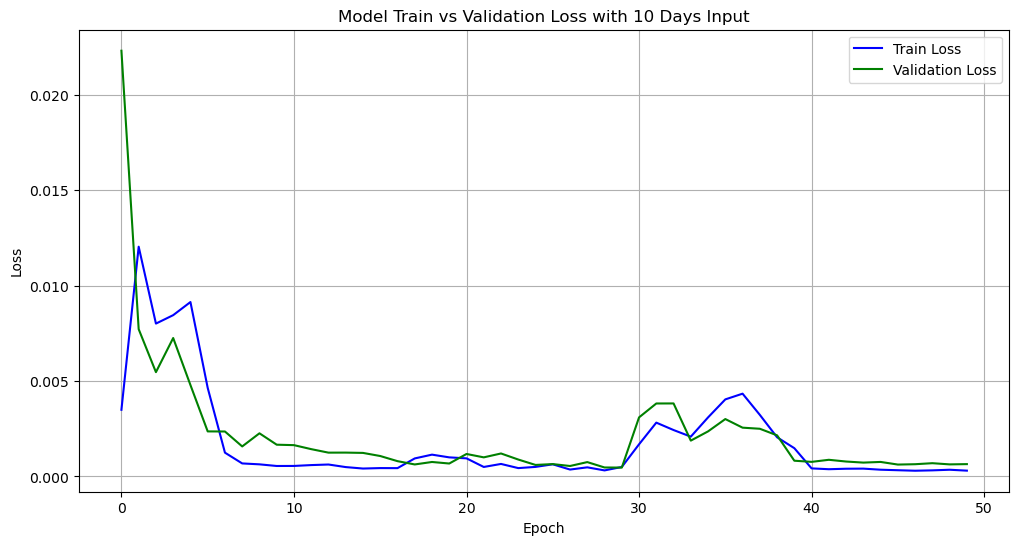

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted stock price for 2024-12-31 (using last 10 days): $383.74


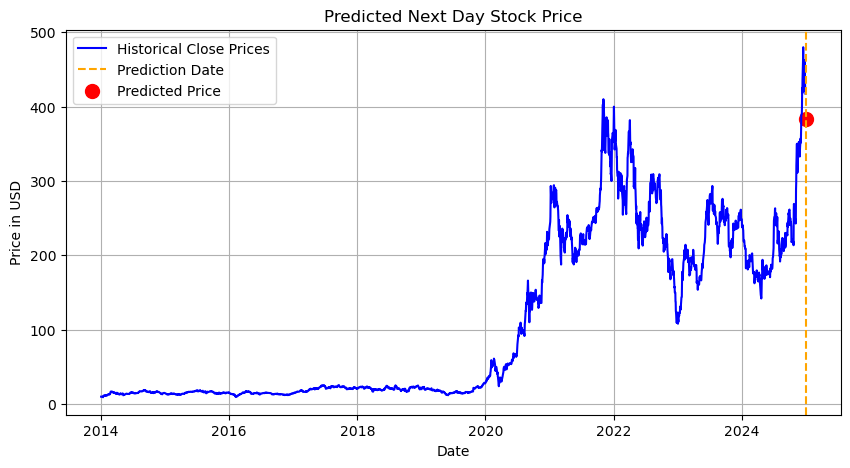

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 5.5238e-04 - val_loss: 0.0043
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - val_loss: 0.0050
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5448e-04 - val_loss: 0.0018
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.2428e-04 - val_loss: 0.0016
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6423e-04 - val_loss: 0.0014
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3707e-04 - val_loss: 0.0015
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3863e-04 - val_loss: 0.0012
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/ste

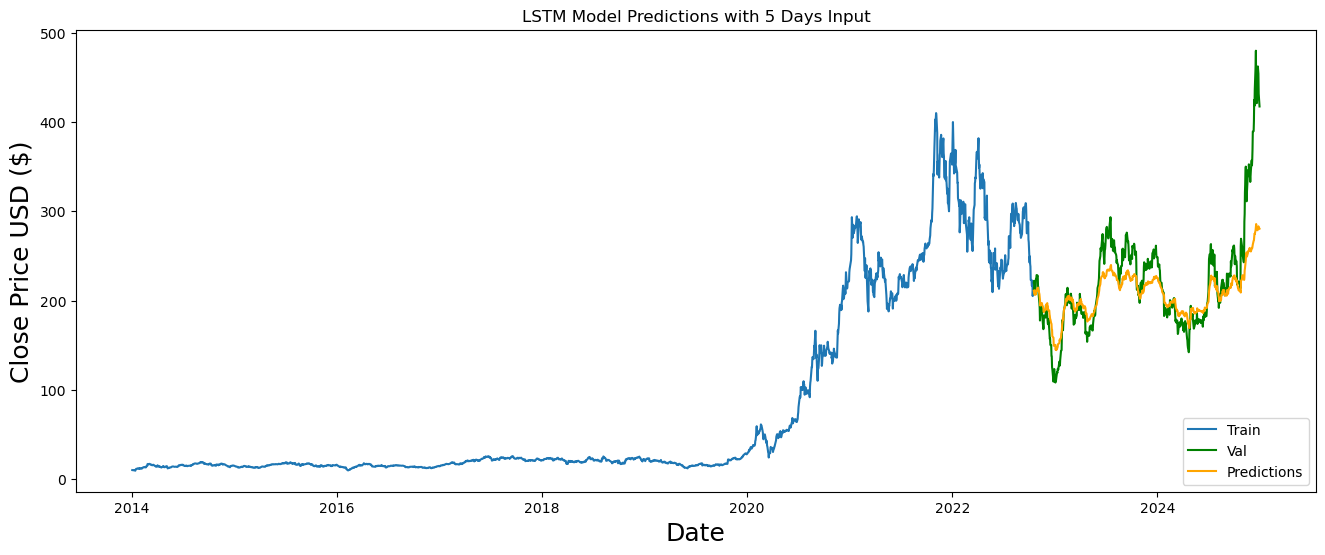

Performance metrics for input days 5:
R² Score: 0.5883
Mean Absolute Error (MAE): 23.1218
Mean Squared Error (MSE): 1362.2894
Root Mean Squared Error (RMSE): 36.9092




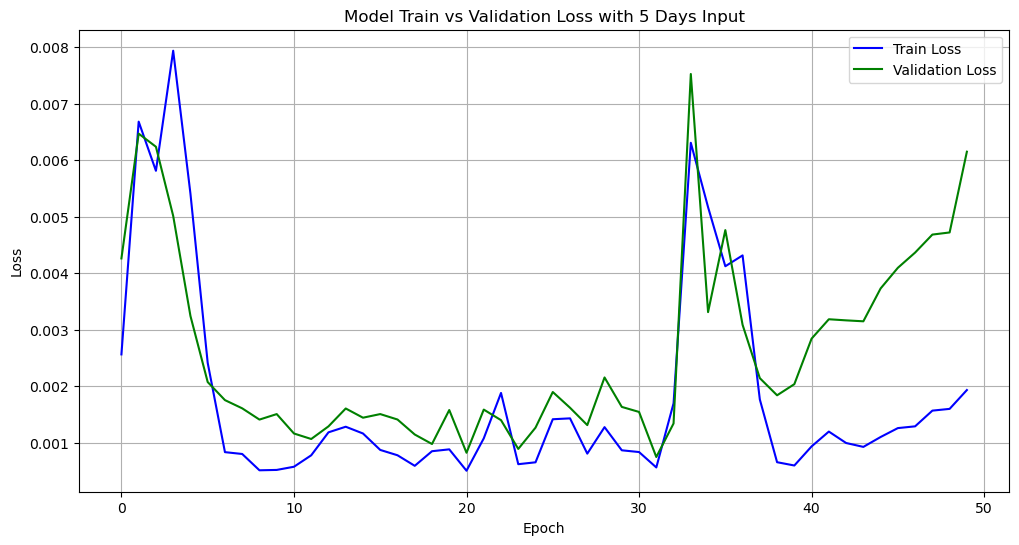

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted stock price for 2024-12-31 (using last 5 days): $278.34


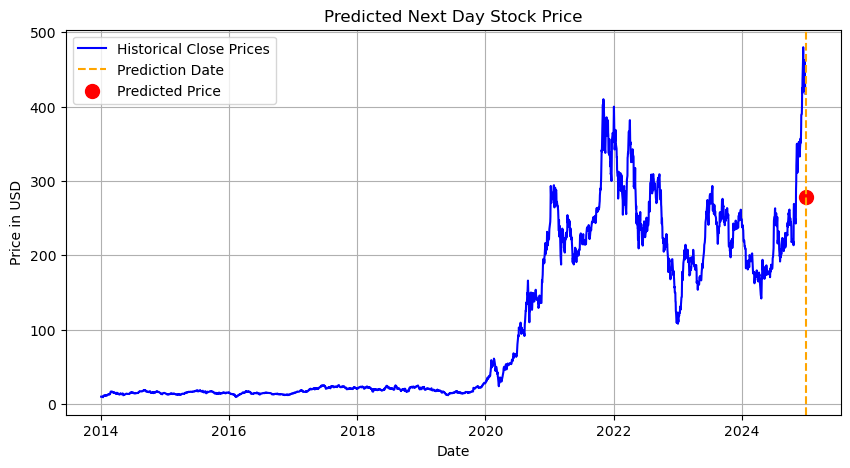

In [ ]:
# Loop through different input lengths
for input_days in input_days_list:
    train_and_predict(input_days)